## Music Generation using Deep Learning

In [1]:
import os
PATH = os.getcwd()

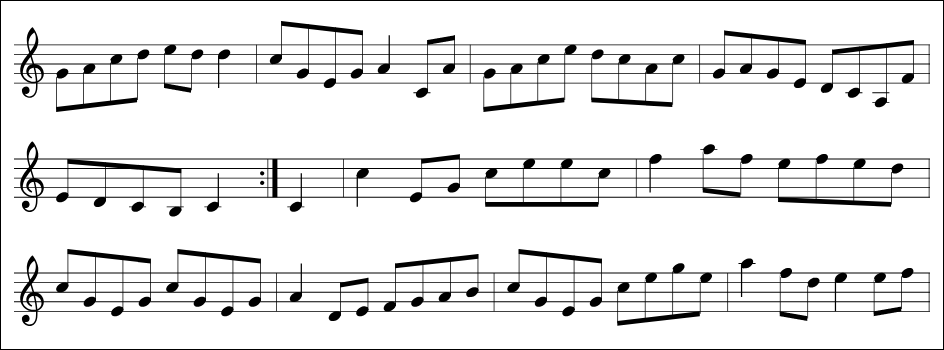

In [17]:
from IPython.display import Image
img_file="../img/Sheet_Music.png"
Image(img_file,width=900, height=400)

In [3]:
import warnings
warnings.filterwarnings("ignore")

import music21
music21.environment.UserSettings()['warnings'] = 0

#### Importing all the libraries

In [4]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import LSTM, Flatten
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


#### Function to prepare notes sequence to train the network

In [5]:
def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()
    print("notes length",len(notes))
    
    # get amount of pitch names
    n_vocab = len(set(notes))
    print("\n")
    print("vocab_size",n_vocab)
    print("\n")
    
    network_input, network_output = prepare_sequences(notes, n_vocab)
    
    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)

#### Function to extract notes from Midi files

In [22]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("../Datasets/Classical/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)
        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    
    with open('./notes_Classic_TD1', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

#### Function to generation Input and Output Sequences

In [23]:
def prepare_sequences(notes, n_vocab):
    
    """ Prepare the sequences used by the Neural Network """
    
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))
    
    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    

    n_patterns = len(network_input)
    
    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    network_output = np_utils.to_categorical(network_output)
        
    return (network_input, network_output)


#### Defining the LSTM Architecture

In [24]:
def create_network(network_input, n_vocab):
    
    model = Sequential()

    model.add(LSTM(128,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(TimeDistributed(Dense(n_vocab)))
    model.add(Flatten())
    
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])

    return model

#### Training the model

In [27]:
def train(model, network_input, network_output):
    """ train the neural network """
    filepath = "../Datasets/Weights/Classical_TD1/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=25, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

if __name__ == '__main__':
    train_network()


Parsing ../Datasets/Classical/2.Aus Liebe will mein Heiland sterban Soprano Aria.mid
Parsing ../Datasets/Classical/3 dances from Henry VIII.mid
Parsing ../Datasets/Classical/02 Menuet.mid
Parsing ../Datasets/Classical/2nd Hungarian Rhapsody.mid
Parsing ../Datasets/Classical/08 Polonaise.mid
Parsing ../Datasets/Classical/2 Polonaises op26 n1.mid
Parsing ../Datasets/Classical/02. Christe Eleison .mid
Parsing ../Datasets/Classical/8 Novelettes op21 n4.mid
Parsing ../Datasets/Classical/8 Songs and Romances op14 n8.mid
Parsing ../Datasets/Classical/8 Novelettes op21 n2.mid


notes length 16710


vocab_size 233


Train on 12457 samples, validate on 4153 samples
Epoch 1/25
12457/12457 [==============================] - 167s 13ms/step - loss: 4.6526 - acc: 0.0414 - val_loss: 4.4519 - val_acc: 0.0554
Epoch 2/25
12457/12457 [==============================] - 162s 13ms/step - loss: 4.4600 - acc: 0.0567 - val_loss: 4.6877 - val_acc: 0.0568
Epoch 3/25
12457/12457 [==============================] - 